### Plotting hyperparameter optimization losses
Multiple hyperparameter experiments have been run. Here combinations of settings are plotted together. 

#### Load in losses finished runs
The code below loads in the losses from a folder with trained models. If you just want to reproduce the figures in the paper, you can skip the two codeblocks below and continue from loading the file with all settings and loss_histories directly from the json file

In [1]:
import os
import json

def load_json_file(file_name):
    with open(file_name, "r") as file:
        data = json.load(file)
    return data

dir_with_models = "../../../data/pytorch/new_corinna_included/trained_models"

history_and_settings_list = []
for model_dir in os.listdir(dir_with_models):
    if model_dir[:4] == "both":
        try:
            history_json_file = os.path.join(dir_with_models, model_dir, "history.json")
            settings_json_file =  os.path.join(dir_with_models, model_dir, "settings.json")
            history = load_json_file(history_json_file)
            settings = load_json_file(settings_json_file)
            history_and_settings_list.append((history, settings))
        except FileNotFoundError:
            print(f"model not finished training: {model_dir}")

model not finished training: both_mode_precursor_mz_ionmode_4000_layers_500_embedding_2024_11_25_09_45_05
model not finished training: both_mode_precursor_mz_ionmode_4000_layers_500_embedding_2024_11_21_09_20_43


In [4]:
with open("./hyperparameter_optimization_history_and_settings.json", "w") as file:
    json.dump(history_and_settings_list, file)

### Load in history and settings
The settings file loaded below is stored in the same folder as this notebook on github.

In [2]:
import os
import json
with open("./hyperparameter_optimization_history_and_settings.json", "r") as file:
    history_and_settings_list = json.load(file)

### load methods

In [3]:
def print_relevant_settings(settings):
    print(settings["average_inchikey_sampling_count"])
    print(settings["fingerprint_nbits"])
    print(settings["base_dims"])
    metadata_types = []
    for metadata in settings["additional_metadata"]:
        metadata_types.append(list(metadata[1].values())[0])
    print(set(metadata_types))


In [4]:
def check_if_correct_constant_settings(settings, settings_to_check):
    for setting_to_check, expected_setting in settings_to_check.items():
        if setting_to_check == "additional_metadata":
            metadata_types = []
            for metadata in settings["additional_metadata"]:
                metadata_types.append(list(metadata[1].values())[0])
            if set(metadata_types) != expected_setting:
                return False
        else:
            if settings[setting_to_check] != expected_setting:
                return False
    return True

In [5]:
def compare_dictionaries(dict1, dict2):
    # Check if the dictionaries are identical
    if dict1 == dict2:
        print("Duplicated settings with the same values.")
    else:
        print("Two settings with same label that do not completely match. Here are the differences:")
        # Find mismatched keys and values
        for key in set(dict1.keys()).union(dict2.keys()):
            value1 = dict1.get(key, "Key not in dict1")
            value2 = dict2.get(key, "Key not in dict2")
            if value1 != value2:
                print(f"Key: {key}, Dict1 Value: {value1}, Dict2 Value: {value2}")

In [16]:
import matplotlib.pyplot as plt
def select_matching_settings(list_of_histories_and_settings, setting_to_vary, settings_to_keep_constant, labels_to_exclude=[]):
    selected_settings_and_losses = {}
    for i, history_and_settings in enumerate(list_of_histories_and_settings):
        history, settings, = history_and_settings
        if check_if_correct_constant_settings(settings, settings_to_keep_constant):
            if setting_to_vary == "additional_metadata":
                metadata_types = []
                for metadata in settings["additional_metadata"]:
                    metadata_types.append(list(metadata[1].values())[0])
                label = ", ".join(set(metadata_types))
            else:
                if isinstance(settings[setting_to_vary], list):
                    label = ", ".join(map(str, settings[setting_to_vary]))
                else:
                    label = str(settings[setting_to_vary])

            if label not in labels_to_exclude:
                if label not in selected_settings_and_losses:
                    selected_settings_and_losses[label] = (history, settings)
                else:
                    # In case of multiple models with similar settings print the differences.
                    print(label)
                    compare_dictionaries(selected_settings_and_losses[label][1], settings)
    return selected_settings_and_losses

def plot_history(selected_settings_and_losses, loss_type="val_losses", save_fig=None, legend_title=""):
    plt.figure(figsize=(8, 4))
    for label in selected_settings_and_losses:
        plt.plot(selected_settings_and_losses[label][0][loss_type], label=label)    
    loss_labels = {"val_rmse": "Validation RMSE", "rmse": "Train RMSE", "val_losses": "Validation MSE", "losses": "Training MSE"}
    plt.ylabel(loss_labels[loss_type])
    plt.xlabel("Epoch")
    plt.legend(loc="upper right", title=legend_title)
    plt.grid()
    if save_fig is None:
        plt.show()
    else:
        plt.savefig(save_fig, format="svg")
        plt.show()

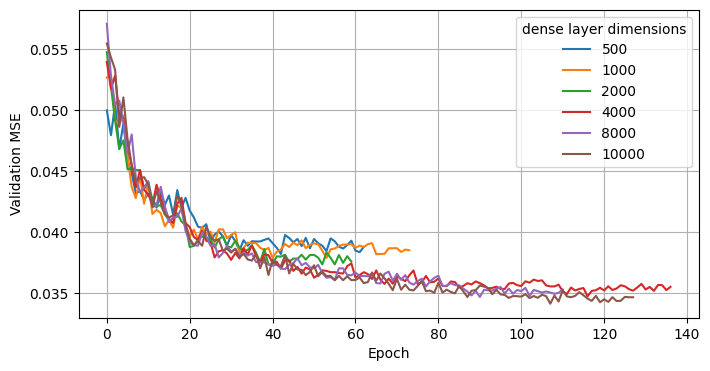

In [25]:
constant_settings = {
    "max_inchikey_sampling": 110,
    "average_inchikey_sampling_count": 100,
    "mz_bin_width": 0.1,
    "fingerprint_nbits": 4096,
    "additional_metadata": {"ionmode", "precursor_mz"},
    "embedding_dim": 500,
    "loss_function": "mse"}
selected_settings_and_losses = select_matching_settings(history_and_settings_list, "base_dims", constant_settings, labels_to_exclude=['1000, 1000', '500, 500, 500', '2000, 2000', '2000, 2000, 2000', '500, 500'])
selected_settings_and_losses = {int(key): value for key, value in selected_settings_and_losses.items()}
sorted_selected_settings_and_losses = {key: selected_settings_and_losses[key] for key in sorted_keys}
plot_history(sorted_selected_settings_and_losses, legend_title="dense layer dimensions",  save_fig="./hyperparameter_optimization/single_layer_dimensions.svg")

100
Two settings with same label that do not completely match. Here are the differences:
Key: max_inchikey_sampling, Dict1 Value: 120, Dict2 Value: 110
Key: time_stamp, Dict1 Value: 2024_11_14_15_39_27, Dict2 Value: 2024_11_21_02_58_46


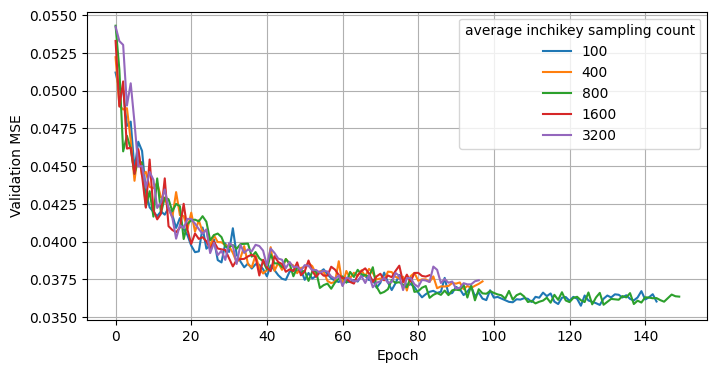

In [30]:
constant_settings = {
    # "max_inchikey_sampling": 120,
    "fingerprint_nbits": 4096,
    "base_dims": [2000],
    "embedding_dim": 500,
    "additional_metadata": {"ionmode", "precursor_mz"},
    "loss_function": "mse",
    "mz_bin_width": 0.1,
    "learning_rate": 0.00025
                             }
selected_settings_and_losses = select_matching_settings(history_and_settings_list, "average_inchikey_sampling_count", constant_settings, 
                                                        labels_to_exclude=["1000", "1200", "2000", "2400", "2800"])
sorted_keys = sorted([int(key) for key in selected_settings_and_losses.keys()])
sorted_selected_settings_and_losses = {str(key): selected_settings_and_losses[str(key)] for key in sorted_keys}

plot_history(sorted_selected_settings_and_losses, legend_title="average inchikey sampling count", save_fig="./hyperparameter_optimization/average_inchikey_sampling_count.svg")

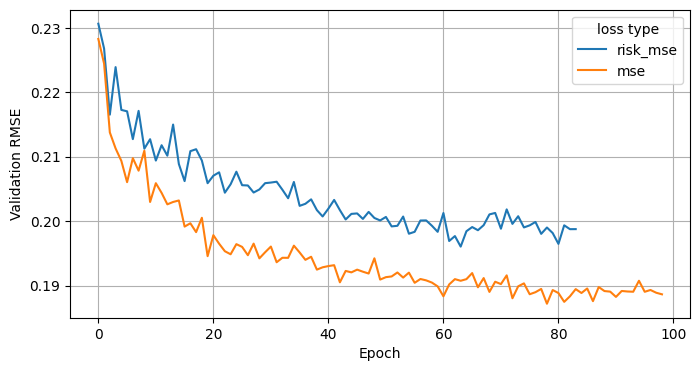

In [19]:
constant_settings = {
    "average_inchikey_sampling_count": 1000,
    "fingerprint_nbits": 4096,
    "base_dims": [2000],
    "additional_metadata": {"ionmode", "precursor_mz"},
    # "loss_function": "mse"
                             }
selected_settings_and_losses = select_matching_settings(history_and_settings_list, "loss_function", constant_settings, 
                                                        labels_to_exclude=[])
plot_history(selected_settings_and_losses, legend_title="loss type", save_fig="./hyperparameter_optimization/risk_mse.svg", loss_type="val_rmse")

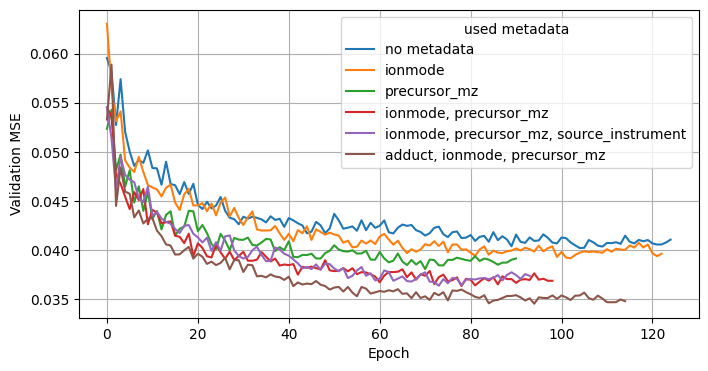

In [18]:
constant_settings = {
    "average_inchikey_sampling_count": 1000,
    "fingerprint_nbits": 4096,
    "base_dims": [2000],
    # "additional_metadata": {"ionmode", "precursor_mz"},
    "loss_function": "mse"}
selected_settings_and_losses = select_matching_settings(history_and_settings_list, "additional_metadata", constant_settings, 
                                                        labels_to_exclude=[])
selected_settings_and_losses["no metadata"] = selected_settings_and_losses.pop("")
sorted_selected_settings_and_losses = {key: selected_settings_and_losses[key] for key in ("no metadata", "ionmode", "precursor_mz", "ionmode, precursor_mz", "ionmode, precursor_mz, source_instrument", "adduct, ionmode, precursor_mz")}
plot_history(sorted_selected_settings_and_losses, legend_title="used metadata",save_fig="./hyperparameter_optimization/additional_metadata.svg")


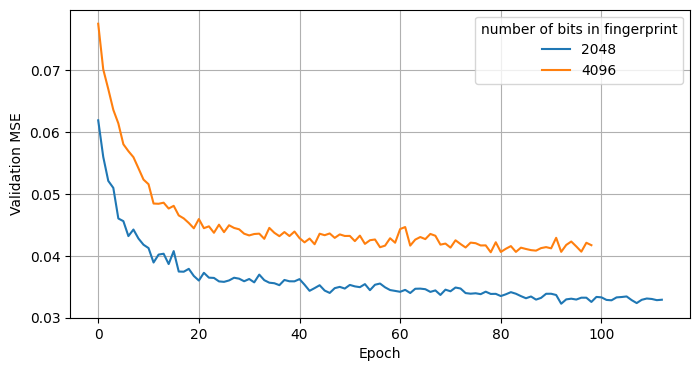

In [149]:
constant_settings = {
    "average_inchikey_sampling_count": 1000,
    # "fingerprint_nbits": 4096,
    "base_dims": [2000, 2000, 2000],
    "additional_metadata": {"ionmode", "precursor_mz"},
    "loss_function": "mse"}
selected_settings_and_losses = select_matching_settings(history_and_settings_list, "fingerprint_nbits", constant_settings, 
                                                        labels_to_exclude=[])
plot_history(selected_settings_and_losses, legend_title= "number of bits in fingerprint", save_fig="./hyperparameter_optimization/fingerprint_nbits.svg")

2000, 2000
Two settings with same label that do not completely match. Here are the differences:
Key: time_stamp, Dict1 Value: 2024_11_21_15_41_54, Dict2 Value: 2024_11_20_13_20_40
Key: learning_rate, Dict1 Value: 1e-05, Dict2 Value: 5e-05
2000, 2000
Two settings with same label that do not completely match. Here are the differences:
Key: time_stamp, Dict1 Value: 2024_11_21_15_41_54, Dict2 Value: 2024_11_20_23_46_21
Key: learning_rate, Dict1 Value: 1e-05, Dict2 Value: 0.0001
2000, 2000
Two settings with same label that do not completely match. Here are the differences:
Key: time_stamp, Dict1 Value: 2024_11_21_15_41_54, Dict2 Value: 2024_11_21_23_36_58
Key: learning_rate, Dict1 Value: 1e-05, Dict2 Value: 0.001


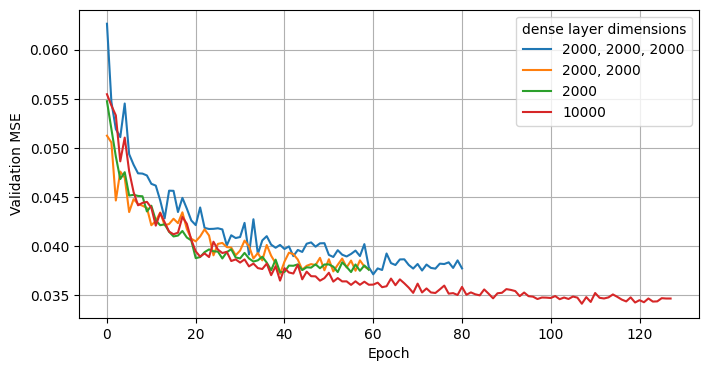

In [26]:
constant_settings = {
    "max_inchikey_sampling": 110,
    "average_inchikey_sampling_count": 100,
    "fingerprint_nbits": 4096, 
    "embedding_dim": 500, 
    "mz_bin_width": 0.1,
    # "learning_rate": 0.00025,
    "additional_metadata": {"ionmode", "precursor_mz"},
    "loss_function": "mse"}

selected_settings_and_losses = select_matching_settings(history_and_settings_list, "base_dims", constant_settings, 
                                                        labels_to_exclude=["1000", "1000, 1000", "8000", "4000", "500", "500, 500", "500, 500, 500"])
sorted_selected_settings_and_losses = {key: selected_settings_and_losses[key] for key in ("2000, 2000, 2000", "2000, 2000", "2000", "10000")}
plot_history(sorted_selected_settings_and_losses, legend_title="dense layer dimensions", save_fig="./hyperparameter_optimization/multilayers_dimensions.svg")

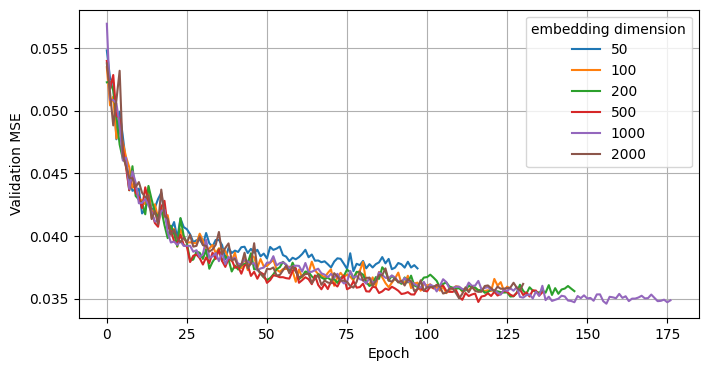

In [31]:
constant_settings = {
    "average_inchikey_sampling_count": 100,
    "fingerprint_nbits": 4096,
    "mz_bin_width": 0.1,
    "base_dims": [4000],
    "additional_metadata": {"ionmode", "precursor_mz"},
    "loss_function": "mse"}

selected_settings_and_losses = select_matching_settings(history_and_settings_list, "embedding_dim", constant_settings, 
                                                        labels_to_exclude=[])
sorted_keys = sorted([int(key) for key in selected_settings_and_losses.keys()])
sorted_selected_settings_and_losses = {str(key): selected_settings_and_losses[str(key)] for key in sorted_keys}
plot_history(sorted_selected_settings_and_losses, legend_title="embedding dimension",save_fig="./hyperparameter_optimization/embedding_dimsensions.svg")


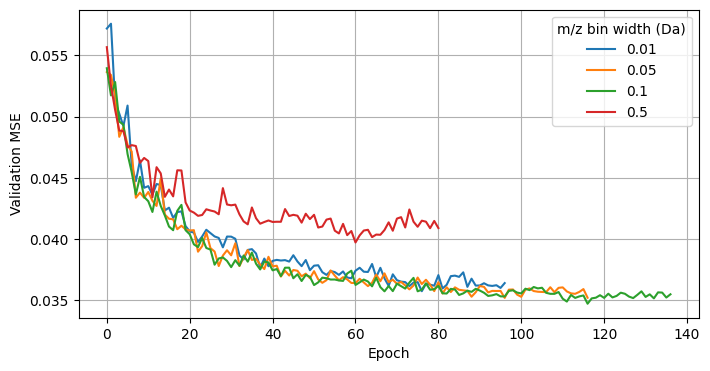

In [37]:
constant_settings = {
    "average_inchikey_sampling_count": 100,
    "fingerprint_nbits": 4096,
    "base_dims": [4000],
    "embedding_dim": 500, 
    "additional_metadata": {"ionmode", "precursor_mz"},
    "loss_function": "mse"}

selected_settings_and_losses = select_matching_settings(history_and_settings_list, "mz_bin_width", constant_settings, 
                                                        labels_to_exclude=[])
selected_settings_and_losses = {float(key): value for key, value in selected_settings_and_losses.items()}
sorted_selected_settings_and_losses = {key: selected_settings_and_losses[key] for key in sorted(selected_settings_and_losses.keys())}
plot_history(sorted_selected_settings_and_losses, legend_title="m/z bin width (Da)",
             save_fig="./hyperparameter_optimization/mz_bin_width.svg")


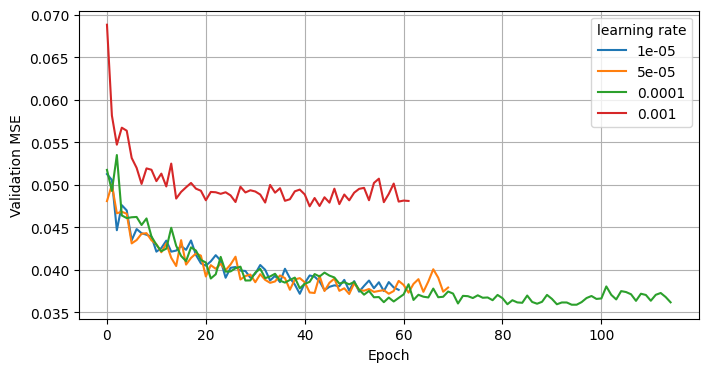

In [38]:
constant_settings = {
    "average_inchikey_sampling_count": 100,
    "fingerprint_nbits": 4096,
    "base_dims": [2000, 2000],
    "embedding_dim": 500, 
    "additional_metadata": {"ionmode", "precursor_mz"},
    "loss_function": "mse"}

selected_settings_and_losses = select_matching_settings(history_and_settings_list, "learning_rate", constant_settings, 
                                                        labels_to_exclude=[])
selected_settings_and_losses = {float(key): value for key, value in selected_settings_and_losses.items()}
sorted_selected_settings_and_losses = {key: selected_settings_and_losses[key] for key in sorted(selected_settings_and_losses.keys())}
plot_history(sorted_selected_settings_and_losses, legend_title="learning rate", 
             save_fig="./hyperparameter_optimization/learning_rate.svg")
